# Accumulation Opportunities

Building VWAP algos given trades

In [4]:
import pandas as pd
import numpy as np
import h5py
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import matplotlib.pyplot as plt
import seaborn as sns
import random
from multiprocessing import Pool, cpu_count

user_pause_time = 0.5

In [5]:
BTC_USD24 = '../data/2024-57__BTC-USD_trades.h5'
BTC_USD23 = '../data/trades_narrow_BTC-USD_2023.delim.gz'
BTC_USD22 = '../data/trades_narrow_BTC-USD_2022.delim.gz'

In [6]:
with h5py.File(BTC_USD24, "r") as h5_file:
    dataset = h5_file["BTC-USDTrades"]["BTC-USDTrades"][:]  # Extract as NumPy array

# Convert to DataFrame (if it's a structured array)
df2024 = pd.DataFrame(dataset)
df2024 = df2024.set_index('timestamp_utc_nanoseconds')


In [7]:
df2023 = pd.read_csv(BTC_USD23, sep='\t')

df2023 = df2023.set_index('timestamp_utc_nanoseconds')

In [8]:
df2022 = pd.read_csv(BTC_USD22, sep='\t')

display(df2022.head())

df2022 = df2022.set_index('timestamp_utc_nanoseconds')

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1643490176220148000,1643490169574850000,38383380000,938300,1.0
1,1643490176220541000,1643490169574850000,38387760000,8937830,1.0
2,1643490176220914000,1643490169574850000,38387770000,46454510,1.0
3,1643490176221462000,1643490169574850000,38388960000,14455400,2.0
4,1643490176221856000,1643490169574850000,38390720000,33673620,1.0


# VWAP Algorithm

In [9]:
def compute_min_size_t(df):
    """
    Compute the 5th percentile of trade sizes to determine `min_size_t`.
    """
    return np.percentile(df["SizeBillionths"] / 1e9, 5)

def vwap_algo(df, target_q, start_t, part_rate, quote_part_ratio, pause_time=0.05, crypto=False):
    """
    Optimized VWAP Participation Algorithm with improved performance and readability.
    """
    quote_part_rate = quote_part_ratio * part_rate

    # Ensure datetime index
    df.index = pd.to_datetime(df.index, unit='ns')
    df = df[df.index >= pd.to_datetime(start_t, unit='ns')]

    # Filter relevant trade side
    trade_sign = 1 if target_q > 0 else -1
    df = df[df['Side'] == -trade_sign]

    if df.empty:
        return {"executed_trades": pd.DataFrame(), "VWAP Price": np.nan, "Total Execution Time": None,
                "Market VWAP": np.nan, "Arrival Price": np.nan, "Participation Rate": np.nan, "Trading Cost": 0.0}

    min_size_t = compute_min_size_t(df)
    arrival_price = df.iloc[0]["PriceMillionths"] / 1e6

    # Group trades by timestamp and price level
    df['Price'] = df['PriceMillionths'] / 1e6
    df['Size'] = df['SizeBillionths'] / 1e9
    df_grouped = df.groupby([df.index, 'Price']).agg({'Size': 'sum'})

    accumulated_q = 0
    total_notional = 0
    executed_trades = []
    total_liquidity = df['Size'].sum()

    last_trade_time = None

    for (timestamp, price), row in df_grouped.iterrows():
        if accumulated_q >= abs(target_q):
            break

        if last_trade_time and (timestamp < last_trade_time + pd.Timedelta(seconds=pause_time)):
            continue

        q_level = row['Size']
        exec_size = min(max(0, (q_level - min_size_t) * quote_part_rate), abs(target_q) - accumulated_q)

        if exec_size > 0:
            executed_trades.append((timestamp, price, exec_size))
            accumulated_q += exec_size
            total_notional += exec_size * price

        last_trade_time = timestamp

    executed_df = pd.DataFrame(executed_trades, columns=['timestamp', 'price', 'size']).set_index('timestamp')

    if executed_df.empty:
        return {"executed_trades": executed_df, "VWAP Price": np.nan, "Total Execution Time": None,
                "Market VWAP": np.nan, "Arrival Price": arrival_price, "Participation Rate": np.nan, "Trading Cost": 0.0}

    vwap_price = (executed_df['price'] * executed_df['size']).sum() / executed_df['size'].sum()
    market_vwap = (df['Price'] * df['Size']).sum() / df['Size'].sum()

    participation_rate = accumulated_q / total_liquidity if total_liquidity else np.nan
    trading_fee = 0.001 if crypto else 0.005
    trading_cost = total_notional * trading_fee

    return {
        "executed_trades": executed_df,
        "VWAP Price": vwap_price,
        "Total Execution Time": executed_df.index[-1] - executed_df.index[0],
        "Market VWAP": market_vwap,
        "Arrival Price": arrival_price,
        "Participation Rate": participation_rate,
        "Trading Cost": trading_cost,
        "VWAP vs Market VWAP": trade_sign * (1 - vwap_price / market_vwap),
        "VWAP vs Arrival Price": trade_sign * (1 - vwap_price / arrival_price)
    }


# Analytics of the trade execution

In [10]:
def analyze_executed_trades(executed_trades_df):
    """
    Analyze the distribution of executed trade volumes and prices.
    
    Parameters:
    - executed_trades_df: DataFrame with 'price' and 'size' columns.
    
    Displays:
    - Histograms for trade volumes (log scale) and prices.
    - Summary statistics.
    """

    if executed_trades_df.empty:
        print("No executed trades to analyze.")
        return

    # Summary statistics
    volume_stats = executed_trades_df['size'].describe()
    price_stats = executed_trades_df['price'].describe()

    print("\nTrade Volume Statistics:")
    print(volume_stats)

    print("\nTrade Price Statistics:")
    print(price_stats)

    # Log-transform trade sizes to handle different magnitudes
    executed_trades_df["log_size"] = np.log1p(executed_trades_df["size"])  # log(1 + size) to avoid log(0)

    # Plot distribution of trade volumes (log scale)
    plt.figure(figsize=(12, 5))
    sns.histplot(executed_trades_df["log_size"], bins=30, kde=True, color="blue")
    plt.xlabel("Log-Scaled Trade Volume (log(1 + size))")
    plt.ylabel("Frequency")
    plt.title("Distribution of Trade Volumes (Log Scale)")
    plt.grid(True)
    plt.show()

    # Plot distribution of trade prices
    plt.figure(figsize=(12, 5))
    sns.histplot(executed_trades_df['price'], bins=30, kde=True, color="green")
    plt.xlabel("Trade Price")
    plt.ylabel("Frequency")
    plt.title("Distribution of Trade Prices")
    plt.grid(True)
    plt.show()


# Testing of the functions with a set of trades from each year

## 2023

In [11]:
res23 = vwap_algo(df2023, target_q=100, start_t=1674521267814309000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)


# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res23['VWAP Price']}")
print(f"Total Execution Time: {res23['Total Execution Time']}")
print(f"Market VWAP During Execution: {res23['Market VWAP']}")
print(f"Arrival Price: {res23['Arrival Price']}")
print(f"Participation Rate: {res23['Participation Rate']}")
print(f"Trading Cost: {res23['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res23['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res23['VWAP vs Arrival Price']}")

VWAP Price Achieved: 22968.75384240126
Total Execution Time: 0 days 15:00:39.066568
Market VWAP During Execution: 22822.01275760184
Arrival Price: 22970.12
Participation Rate: 0.005994161923342581
Trading Cost: 11484.376921200726
VWAP improvement on Market VWAP: -0.006429804695930796
VWAP improvement on Arrival Price: 5.9475422798827005e-05



Trade Volume Statistics:
count    3.407500e+04
mean     2.934703e-03
std      7.605125e-03
min      5.000000e-10
25%      1.365805e-04
50%      6.135000e-04
75%      2.280331e-03
max      2.586128e-01
Name: size, dtype: float64

Trade Price Statistics:
count    34075.000000
mean     22980.266850
std        102.592909
min      22714.000000
25%      22897.805000
50%      22972.730000
75%      23083.080000
max      23165.190000
Name: price, dtype: float64


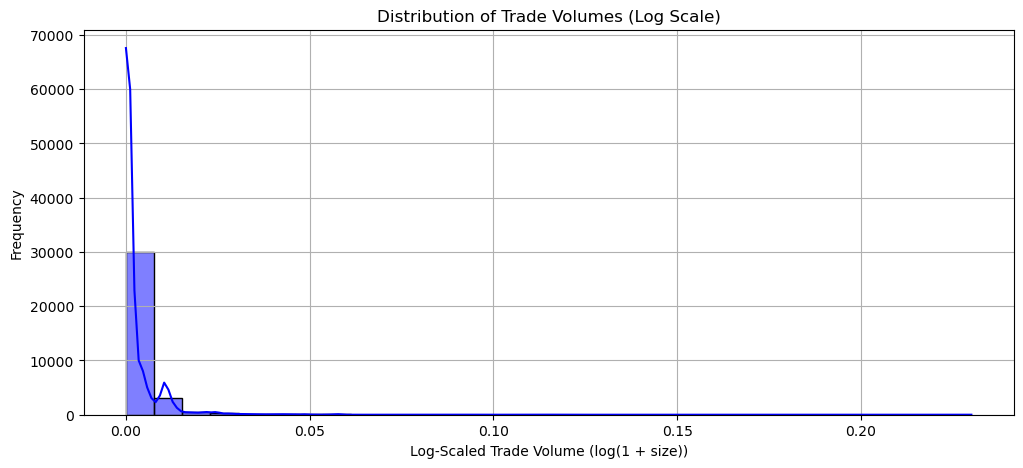

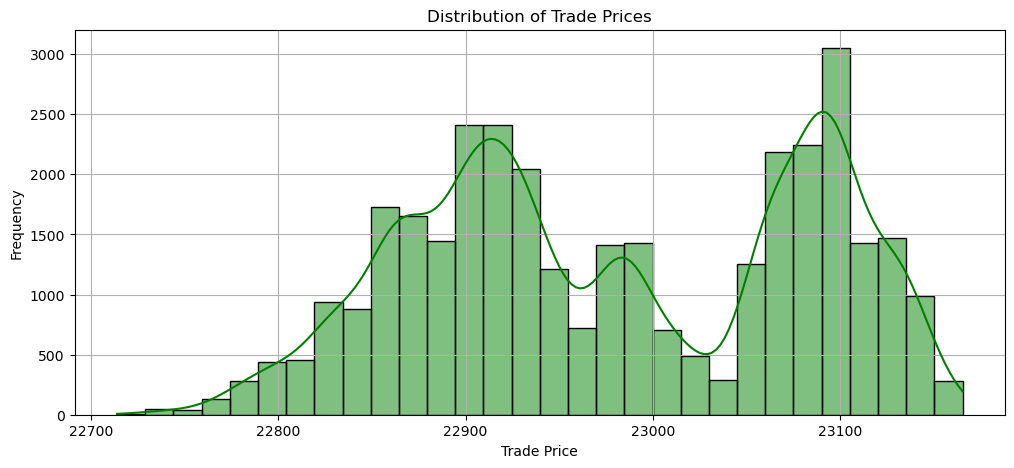

In [12]:
analyze_executed_trades(res23['executed_trades'])

# 2022

In [13]:
res24 = vwap_algo(df2024, target_q=100, start_t=1706390853901420000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)

# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res24['VWAP Price']}")
print(f"Total Execution Time: {res24['Total Execution Time']}")
print(f"Market VWAP During Execution: {res24['Market VWAP']}")
print(f"Arrival Price: {res24['Arrival Price']}")
print(f"Participation Rate: {res24['Participation Rate']}")
print(f"Trading Cost: {res24['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res24['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res24['VWAP vs Arrival Price']}")

VWAP Price Achieved: 42986.93452369576
Total Execution Time: 3 days 04:06:46.125409
Market VWAP During Execution: 42864.352751404585
Arrival Price: 42169.21
Participation Rate: 0.015880207905532878
Trading Cost: 141.83410143322206
VWAP improvement on Market VWAP: -0.00285976025351653
VWAP improvement on Arrival Price: -0.019391506829171457



Trade Volume Statistics:
count    3.760000e+02
mean     1.755037e-03
std      4.632528e-03
min      5.239500e-07
25%      3.379532e-05
50%      2.653885e-04
75%      1.145090e-03
max      5.949822e-02
Name: size, dtype: float64

Trade Price Statistics:
count      376.000000
mean     42804.866543
std        610.576160
min      41737.000000
25%      42210.712500
50%      42910.025000
75%      43387.770000
max      43752.490000
Name: price, dtype: float64


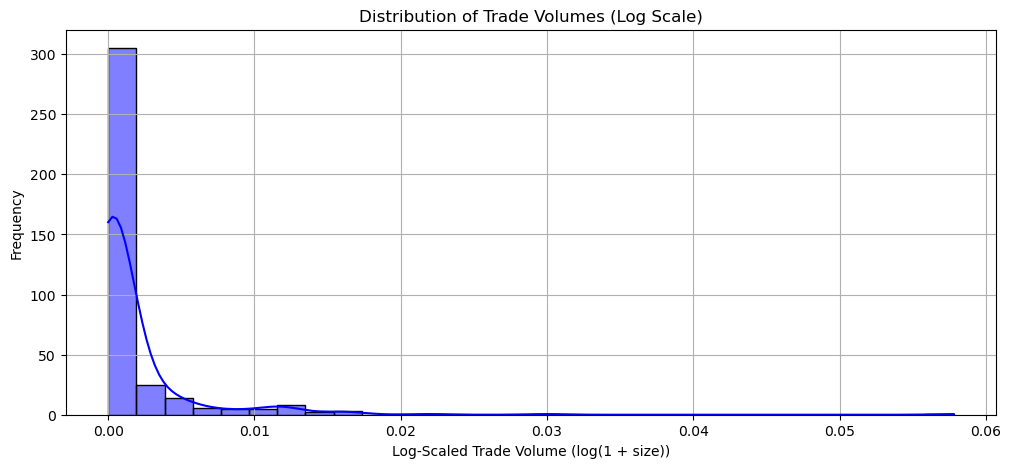

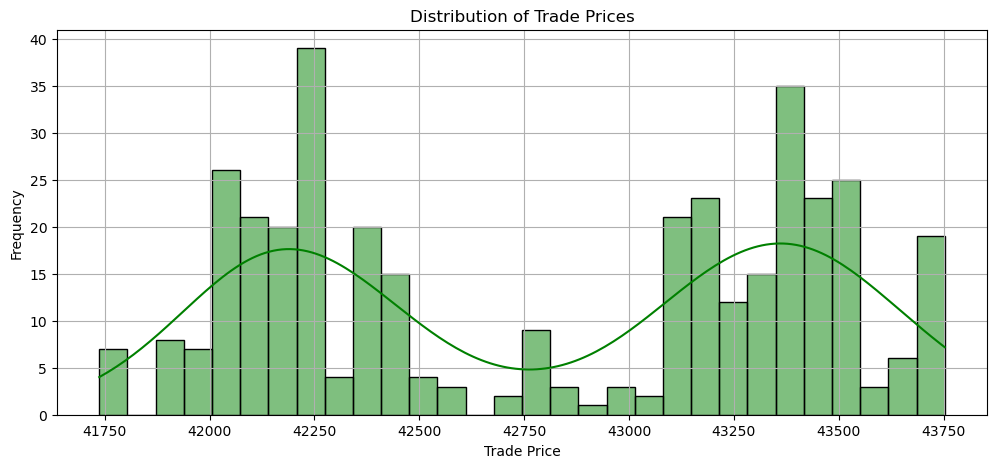

In [14]:
analyze_executed_trades(res24['executed_trades'])

# 2022

In [15]:
res22 = vwap_algo(df2022, target_q=100, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05)

# Print VWAP Price and Execution Metrics
print(f"VWAP Price Achieved: {res22['VWAP Price']}")
print(f"Total Execution Time: {res22['Total Execution Time']}")
print(f"Market VWAP During Execution: {res22['Market VWAP']}")
print(f"Arrival Price: {res22['Arrival Price']}")
print(f"Participation Rate: {res22['Participation Rate']}")
print(f"Trading Cost: {res22['Trading Cost']}")
print(f"VWAP improvement on Market VWAP: {res22['VWAP vs Market VWAP']}")
print(f"VWAP improvement on Arrival Price: {res22['VWAP vs Arrival Price']}")

VWAP Price Achieved: 37614.89142342158
Total Execution Time: 1 days 15:17:18.827492
Market VWAP During Execution: 38224.6250057338
Arrival Price: 38388.54
Participation Rate: 0.002679898808417544
Trading Cost: 18807.445711710494
VWAP improvement on Market VWAP: 0.015951329338633302
VWAP improvement on Arrival Price: 0.020153112792995587



Trade Volume Statistics:
count    8.455600e+04
mean     1.182648e-03
std      4.634431e-03
min      5.000000e-10
25%      3.969750e-05
50%      1.845045e-04
75%      7.719808e-04
max      4.313525e-01
Name: size, dtype: float64

Trade Price Statistics:
count    84556.000000
mean     37709.739571
std        474.637352
min      36648.520000
25%      37226.770000
50%      37881.865000
75%      38046.680000
max      38737.980000
Name: price, dtype: float64


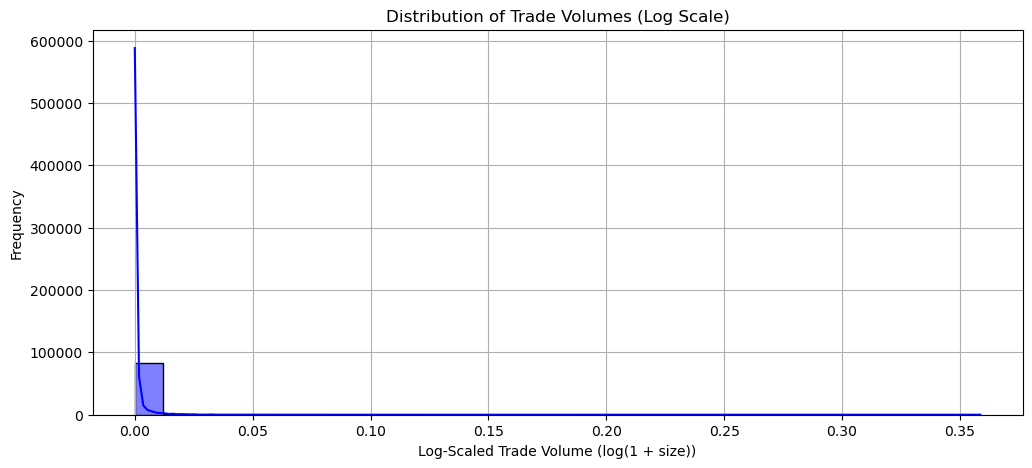

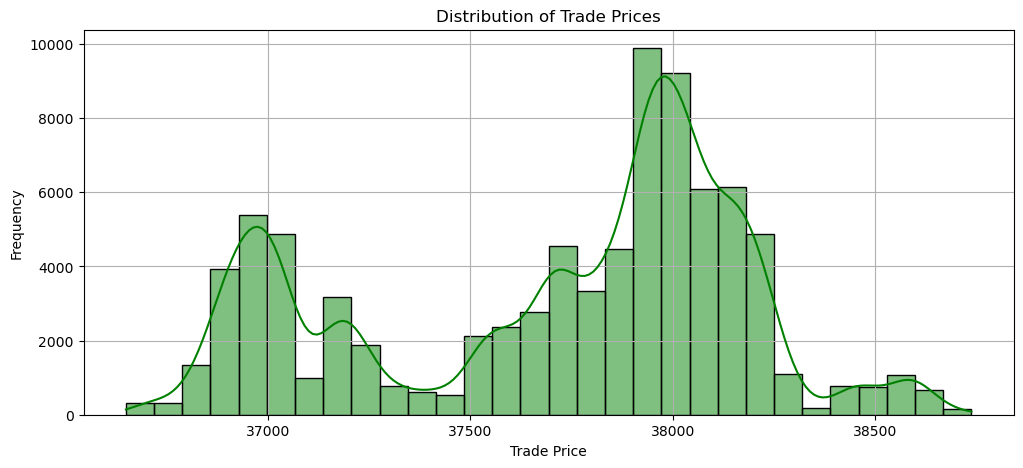

In [16]:
analyze_executed_trades(res22['executed_trades'])

## Commentary on Initial Analysis:

The VWAPs we execute are all relatively long and start at the beginning of the trading period. Interestingly, we see 2 modes in the distribution of trades made in 2023 and 2024 and a single mode for 2022. 

This is just the BTC and USD market so we can't comment on other markets but let's see if this persists.

I chose 100 shares because it seems to cover the entire time span.

First impression, our VWAP is not improving much upon the prices we are observing which is to be expected.

# Trade windows

We will now look for volumes such that we can can build the position in around 15 minutes

In [17]:
dict22 = {}
dict23 = {}
dict24 = {}

# second half is the crypto tag

delim_pairs = [('BTC-USD', False), ('ETH-BTC', True), ('ETH-USD', False)]
h5_pairs = [('BTC-USD', False), ('ETH-BTC', True), ('ETH-USD', False), ('SOL-ETH', True), ('SOL-USD', False)]



In [18]:
with h5py.File(BTC_USD24, "r") as h5_file:
    dataset = h5_file["BTC-USDTrades"]["BTC-USDTrades"][:]  # Extract as NumPy array

# Convert to DataFrame (if it's a structured array)
df2024 = pd.DataFrame(dataset)
df2024 = df2024.set_index('timestamp_utc_nanoseconds')

df2023 = pd.read_csv(BTC_USD23, sep='\t')

df2023 = df2023.set_index('timestamp_utc_nanoseconds')

In [19]:
for pair, crypto in delim_pairs:
    path22 = f'../data/trades_narrow_{pair}_2022.delim.gz'
    path23 = f'../data/trades_narrow_{pair}_2023.delim.gz'

    df22 = pd.read_csv(path22, sep='\t').set_index('timestamp_utc_nanoseconds')
    df23 = pd.read_csv(path23, sep='\t').set_index('timestamp_utc_nanoseconds')

    dict22[pair] = (df22, crypto)
    dict23[pair] = (df23, crypto)

for pair, crypto in h5_pairs:
    path24 = f'../data/2024-57__{pair}_trades.h5'

    with h5py.File(path24, "r") as h5_file:
        dataset = h5_file[f"{pair}Trades"][f"{pair}Trades"][:]

    df24 = pd.DataFrame(dataset).set_index('timestamp_utc_nanoseconds')

    dict24[pair] = (df24, crypto)


## Look for volume windows for each df that yield desired time VWAP

### 2022

In [20]:
# BTC-USD: target quantity of 2
prod = 'BTC-USD'

res22 = vwap_algo(dict22[prod][0], target_q=2, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 2)

Total Execution Time: 0 days 00:22:48.661667


In [21]:
# ETH-BTC: target quantity of 2
prod = 'ETH-BTC'

res22 = vwap_algo(dict22[prod][0], target_q=2, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 2)

Total Execution Time: 0 days 00:16:34.676463


In [22]:
# ETH-USD: target quantity of 1.4
# at 1.3, it takes 8 seconds
prod = 'ETH-USD'

res22 = vwap_algo(dict22[prod][0], target_q=1.4, start_t=1643490169574850000, part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict22[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res22['Total Execution Time']}")

dict22[prod] = (dict22[prod][0], dict22[prod][1], 1.4)

Total Execution Time: 0 days 00:01:01.552375


## 2023

In [23]:
# BTC-USD: target quantity of 2
prod = 'BTC-USD'

res23 = vwap_algo(dict23[prod][0], target_q=2, start_t=dict23[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 2)

Total Execution Time: 0 days 00:20:38.052619


In [24]:
# ETH-BTC: target quantity of 1.2, large pockets of volume
# high variance in time 
prod = 'ETH-BTC'

res23 = vwap_algo(dict23[prod][0], target_q=1.2, start_t=dict23[prod][0].index[300], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 1.2)

Total Execution Time: 0 days 15:16:21.436690


In [25]:
# ETH-USD: target quantity of 10
prod = 'ETH-USD'

res23 = vwap_algo(dict23[prod][0], target_q=10, start_t=dict23[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict23[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res23['Total Execution Time']}")

dict23[prod] = (dict23[prod][0], dict23[prod][1], 10)

Total Execution Time: 0 days 00:11:53.868009


## 2024

In [26]:
# BTC-USD: target quantity of 0.005
# volumes are chunky and high variance
prod = 'BTC-USD'

res24 = vwap_algo(dict24[prod][0], target_q=0.005, start_t=dict24[prod][0].index[300], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.005)

Total Execution Time: 0 days 00:59:41.715395


In [27]:
# ETH-BTC: target quantity of 0.1
# volumes are chunky and high variance
prod = 'ETH-BTC'

res24 = vwap_algo(dict24[prod][0], target_q=0.1, start_t=dict24[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.1)

Total Execution Time: 0 days 02:53:21.655516


In [28]:
# BTC-USD: target quantity of 0.1
# volumes are chunky and high variance
prod = 'ETH-USD'

res24 = vwap_algo(dict24[prod][0], target_q=0.1, start_t=dict24[prod][0].index[0], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 0.1)

Total Execution Time: 0 days 01:00:08.178191

In [29]:
# SOL-USD: target quantity of 2
# volumes are chunky and high variance
prod = 'SOL-USD'

res24 = vwap_algo(dict24[prod][0], target_q=2, start_t=dict24[prod][0].index[400], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 2)

Total Execution Time: 0 days 02:59:39.918285


In [30]:
# SOL-ETH: target quantity of 2
prod = 'SOL-ETH'

res24 = vwap_algo(dict24[prod][0], target_q=2, start_t=dict24[prod][0].index[400], part_rate=0.02, quote_part_ratio=2.5, pause_time=0.05, crypto=dict24[prod][1])

# Print VWAP Price and Execution Metrics
print(f"Total Execution Time: {res24['Total Execution Time']}")

dict24[prod] = (dict24[prod][0], dict24[prod][1], 2)

Total Execution Time: 0 days 02:00:02.706104


## Commentary on parameter initialization

It seems as though we are taking relatively low volumes. However, there are points in the dataset with relatively large volumes occurring as we see chunky changes in the time it takes to attain just 0.1 more shares of volume in our VWAP. 

Our volume selection may not be the most optimal in this aspect given a randomization in time selection.

# Analysis

I will take random samples of size 100. This is mainly trying to maintain independence.

## What factors am I looking for?

VWAP vs Market VWAP and Arrival Price

Real Participation Rate vs Target Participation Rate (depending on k)

Time distribution

# Simulation function

In [31]:
def run_simulation_for_product(args):
    d, prod, num_simulations = args
    results = {
        'VWAP_vs_Market_VWAP': [],
        'VWAP_vs_Arrival_Price': [],
        'Participation_Rate_Diff': [],
        'Execution_Time': []
    }

    df = d[prod][0]
    crypto = d[prod][1]
    target_q = d[prod][2]
    start_times = random.sample(list(df.index), min(num_simulations, len(df.index)))

    for start_t in start_times:
        res = vwap_algo(
            df, 
            target_q=target_q, 
            start_t=start_t, 
            part_rate=0.02, 
            quote_part_ratio=2.5, 
            pause_time=0.05, 
            crypto=crypto
        )

        if res['VWAP vs Market VWAP'] is not np.nan and res['VWAP vs Arrival Price'] is not np.nan:
            results['VWAP_vs_Market_VWAP'].append(res['VWAP vs Market VWAP'])
            results['VWAP_vs_Arrival_Price'].append(res['VWAP vs Arrival Price'])

        if res['Participation Rate'] is not np.nan:
            participation_rate_diff = res['Participation Rate'] - 0.02  # Target participation rate is 0.02
            results['Participation_Rate_Diff'].append(participation_rate_diff)

        if res['Total Execution Time']:
            execution_time_seconds = res['Total Execution Time'].total_seconds()
            results['Execution_Time'].append(execution_time_seconds)

    print(f'Done with product: {prod}')
    return results

def merge_results(results_list):
    merged_results = {
        'VWAP_vs_Market_VWAP': [],
        'VWAP_vs_Arrival_Price': [],
        'Participation_Rate_Diff': [],
        'Execution_Time': []
    }
    for results in results_list:
        for key in merged_results:
            merged_results[key].extend(results[key])
    return merged_results

def run_simulations(dicts, num_simulations=2):
    args_list = [(d, prod, num_simulations) for d in dicts for prod in d]

    results_list = [run_simulation_for_product(args) for args in args_list]

    return merge_results(results_list)

In [32]:
def plot_histograms(results):
    plt.figure()
    plt.hist(results['VWAP_vs_Market_VWAP'], bins=30, alpha=0.7)
    plt.title('VWAP vs Market VWAP Distribution')
    plt.xlabel('VWAP vs Market VWAP')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    plt.hist(results['VWAP_vs_Arrival_Price'], bins=30, alpha=0.7)
    plt.title('VWAP vs Arrival Price Distribution')
    plt.xlabel('VWAP vs Arrival Price')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    plt.hist(results['Participation_Rate_Diff'], bins=30, alpha=0.7)
    plt.title('Real Participation Rate vs Target Participation Rate')
    plt.xlabel('Participation Rate Difference')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    plt.hist(results['Execution_Time'], bins=30, alpha=0.7)
    plt.title('Total Execution Time Distribution')
    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Frequency')
    plt.show()

In [3]:
# Run simulations
results = run_simulations([dict22, dict23, dict24])

# Plot histograms
plot_histograms(results)

NameError: name 'dict22' is not defined